#  0. Import python module 

In [9]:
%matplotlib inline

from sklearn.linear_model import LinearRegression
import sklearn.metrics
import sklearn.linear_model
import pandas
import numpy
import scipy
import datetime
import matplotlib.pyplot
import matplotlib.dates
import math

# 1. Harvest data

## 1.1 Load havest data and reformat it

In [10]:
df_gt_harvest = pandas.read_csv("data/2018_08_ground_truth.csv")

for column_name in ['poids_moy_1_fruit',
                    'poids_recolte',
                    'poids_recoltes_avec_sol',
                    'Nb_fruits_recoltes',
                    'Nb_fruits_recoltes_avec_sol']:
    
    # Convert in numeric format
    df_gt_harvest[column_name] = pandas.to_numeric(df_gt_harvest[column_name], 
                                                   downcast='float', 
                                                   errors='coerce')

# Convert date in datetime
df_gt_harvest['date_recolte'] = pandas.to_datetime(df_gt_harvest['date_recolte'], 
                                                   format='%m/%d/%Y', 
                                                   errors='coerce', 
                                                   utc=False)

# Select measurements only for data scanned
# df_gt_harvest = df_gt_harvest[numpy.bitwise_and(df_gt_harvest['Ligne'] <= 4, 
#                                                 df_gt_harvest['Position'] <= 20)]

# Select data after the scan time periode
df_gt_harvest = df_gt_harvest[df_gt_harvest['date_recolte'] >= pandas.Timestamp('2018-08-02')]

# Remove NAN value
df_gt_harvest = df_gt_harvest.dropna()

df_gt_harvest["harvest_nb_fruit_floor"] =  df_gt_harvest["Nb_fruits_recoltes_avec_sol"] - df_gt_harvest["Nb_fruits_recoltes"]
df_gt_harvest["harvest_weight_fruit_floor"] =  df_gt_harvest["poids_recoltes_avec_sol"] - df_gt_harvest["poids_recolte"]

df_gt_harvest = df_gt_harvest.rename(
    columns={"Ligne": "line", 
             "Position": "position", 
             "Nb_fruits_recoltes_avec_sol": "harvest_nb_fruit",
             "poids_recoltes_avec_sol": "harvest_weight_fruit",
             "poids_recolte": "harvest_weight_fruit_tree",
             "Nb_fruits_recoltes": "harvest_nb_fruit_tree"})

# Plot the dataframe
df_gt_harvest

,date_recolte,WT,line,position,code,Geno,poids_moy_1_fruit,harvest_weight_fruit_tree,harvest_nb_fruit_tree,harvest_weight_fruit,harvest_nb_fruit,harvest_nb_fruit_floor,harvest_weight_fruit_floor
0,2018-09-14,WW,1,1,36.0,X0036,0.107,8.590000,79.981003,11.919000,110.981003,31.000000,3.329
1,2018-09-14,WD,2,1,36.0,X0036,0.095,0.667000,7.000000,1.239000,13.000000,6.000000,0.572
8,2018-08-27,WW,1,3,156.0,X0156,0.211,22.190001,105.066002,25.780001,122.066002,17.000000,3.590
9,2018-08-27,WD,2,3,156.0,X0156,0.162,23.350000,143.781006,26.273001,161.781006,18.000000,2.923
10,2018-08-30,WW,7,85,156.0,X0156,0.170,19.930000,116.959999,22.486000,131.960007,15.000008,2.556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2018-09-12,WW,5,46,9436.0,X9436,0.070,6.880000,98.567001,9.672000,138.567001,40.000000,2.792
920,2018-09-12,WD,6,46,9436.0,X9436,0.083,5.570000,67.108002,6.815000,82.108002,15.000000,1.245
921,2018-09-20,WD,10,43,9436.0,X9436,0.087,20.250000,232.225006,25.656000,294.225006,62.000000,5.406
924,2018-08-30,WW,7,73,9437.0,X9437,0.103,0.310000,3.000000,0.723000,7.000000,4.000000,0.413


In [ ]:
df_gt_harvest = pandas.read_csv("data/harvest_data_2019.csv")
df_gt_harvest

for column_name in ['poids_moy_1_fruit',
                    'poids_recolte',
                    'poids_recoltes_avec_sol',
                    'Nb_fruits_recoltes',
                    'Nb_fruits_recoltes_avec_sol']:
    
    # Convert in numeric format
    df_gt_harvest[column_name] = pandas.to_numeric(df_gt_harvest[column_name], 
                                                   downcast='float', 
                                                   errors='coerce')

# Convert date in datetime
df_gt_harvest['date_recolte'] = pandas.to_datetime(df_gt_harvest['date_recolte'], 
                                                   format='%m/%d/%Y', 
                                                   errors='coerce', 
                                                   utc=False)

# Select data after the scan time periode
df_gt_harvest = df_gt_harvest[df_gt_harvest['date_recolte'] >= pandas.Timestamp('2019-09-09')]

df_gt_harvest["harvest_nb_fruit_floor"] =  df_gt_harvest["Nb_fruits_recoltes_avec_sol"] - df_gt_harvest["Nb_fruits_recoltes"]
df_gt_harvest["harvest_weight_fruit_floor"] =  df_gt_harvest["poids_recoltes_avec_sol"] - df_gt_harvest["poids_recolte"]

df_gt_harvest = df_gt_harvest.rename(
    columns={"Ligne": "line", 
             "Position": "position", 
             "Nb_fruits_recoltes_avec_sol": "harvest_nb_fruit",
             "poids_recoltes_avec_sol": "harvest_weight_fruit",
             "poids_recolte": "harvest_weight_fruit_tree",
             "Nb_fruits_recoltes": "harvest_nb_fruit_tree"})

# Plot the dataframe
df_gt_harvest

# 2. Automatic Field Measurements

## 2.1 Load data

In [19]:
# Load the autmatic measurements
# df_automatic_measurements = pandas.read_csv('field_measurements.csv')
# df_automatic_measurements = pandas.read_csv('field_measurements_OPTICS.csv')
df_automatic_measurements = pandas.read_csv('field_RF_50_DBSCAN.csv')


df_automatic_measurements['date'] = pandas.to_datetime(df_automatic_measurements['date'], 
                                                   format='%Y_%m_%d', 
                                                   errors='coerce', 
                                                   utc=False)


# df_automatic_measurements = df_automatic_measurements[
#     df_automatic_measurements['date'] >= pandas.Timestamp('2019-09-08')]

# df_automatic_measurements = df_automatic_measurements[
#     df_automatic_measurements['date'] < pandas.Timestamp('2019-09-08')]

#df_automatic_measurements = df_automatic_measurements[df_automatic_measurements['basename'].str.contains("high_quality")]

# plot automatic measurements dataframe
df_automatic_measurements

,basename,date,line,position,nb_fruit
0,tree_2019_09_17_L05_P07.txt,2019-09-17,5,7,10
1,tree_2018_08_03_L05_P02.txt,2018-08-03,5,2,11
2,tree_2018_08_03_L05_P07.txt,2018-08-03,5,7,31
3,tree_2019_09_17_L03_P04.txt,2019-09-17,3,4,38
4,tree_2019_09_17_L05_P12.txt,2019-09-17,5,12,53
...,...,...,...,...,...
274,tree_2019_09_11_L08_P01_high_quality.txt,2019-09-11,8,1,163
275,tree_2019_09_11_L08_P04_high_quality.txt,2019-09-11,8,4,134
276,tree_2019_09_09_L05_P01_high_quality.txt,2019-09-09,5,1,112
277,tree_2019_09_09_L05_P03_high_quality.txt,2019-09-09,5,3,90


# 4. Comparison between ground truth and automatic measurements

## 4.1 Merge the data

In [20]:
df_comparison = pandas.merge(df_gt_harvest, 
                             df_automatic_measurements, 
                             left_on=['line', 'position'], 
                             right_on=['line', 'position'])

# df_comparison = df_comparison[df_comparison['position'].isin([1, 5, 6, 10, 11, 15, 16, 20])]
# df_comparison = df_comparison[df_comparison['position'].isin([2, 4, 7, 9, 12, 14, 17, 19])]
# df_comparison = df_comparison[df_comparison['position'].isin([3, 8, 13, 18])]

df_comparison

,date_recolte,WT,line,position,code,Geno,poids_moy_1_fruit,harvest_weight_fruit_tree,harvest_nb_fruit_tree,harvest_weight_fruit,harvest_nb_fruit,harvest_nb_fruit_floor,harvest_weight_fruit_floor,basename,date,nb_fruit
0,2018-09-14,WW,1,1,36.0,X0036,0.107,8.590000,79.981003,11.919000,110.981003,31.0,3.329000,tree_2018_08_02_L01_P01.txt,2018-08-02,52
1,2018-09-14,WD,2,1,36.0,X0036,0.095,0.667000,7.000000,1.239000,13.000000,6.0,0.572000,tree_2018_08_02_L02_P01.txt,2018-08-02,44
2,2018-08-27,WW,1,3,156.0,X0156,0.211,22.190001,105.066002,25.780001,122.066002,17.0,3.590000,tree_2018_08_02_L01_P03.txt,2018-08-02,40
3,2018-08-27,WD,2,3,156.0,X0156,0.162,23.350000,143.781006,26.273001,161.781006,18.0,2.923000,tree_2018_08_02_L02_P03.txt,2018-08-02,37
4,2018-09-11,WD,2,4,337.0,X0337,0.216,13.620000,63.000000,16.430000,76.000000,13.0,2.810000,tree_2018_08_02_L02_P04.txt,2018-08-02,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2018-08-28,WD,6,20,9151.0,X9151,0.141,36.189999,257.031006,39.428001,280.031006,23.0,3.238003,tree_2018_08_03_L06_P20.txt,2018-08-03,123
225,2018-09-13,WW,7,13,9153.0,X9153,0.173,1.900000,11.000000,4.664000,27.000000,16.0,2.764000,tree_2018_08_03_L07_P13.txt,2018-08-03,23
226,2018-09-13,WD,8,13,9153.0,X9153,0.058,9.000000,154.110001,11.862000,203.110001,49.0,2.862000,tree_2018_08_03_L08_P13.txt,2018-08-03,30
227,2018-08-30,WW,7,11,9256.0,X9256,0.215,12.900000,59.889000,23.670000,109.889000,50.0,10.770000,tree_2018_08_03_L07_P11.txt,2018-08-03,68


In [13]:
matplotlib.pyplot.rcParams["figure.figsize"] = (15, 15)
camp = matplotlib.pyplot.get_cmap('hsv', 20)

def plot_R2_linear_model(axis, df_colum_1, df_colum_2, color='r'):

    X = numpy.array([df_colum_1.to_numpy()]).T
    y = df_colum_2.to_numpy()
    
    axis.plot(X, y, c=color, marker='.', linestyle='', markersize=20)
    
    reg = sklearn.linear_model.LinearRegression(fit_intercept=True).fit(X, y)
    # slope
    # inercept
    axis.plot(X, reg.predict(X), 'b--', label="R² = {0:.2f}".format(reg.score(X, y)))
    
    reg = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(X, y)
    axis.plot(X, reg.predict(X), 'k--', label="R² = {0:.2f}".format(reg.score(X, y)))
    
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, fontsize=40)
    
    axis.set_xlabel(df_colum_1.name, fontsize=40)
    axis.set_ylabel(df_colum_2.name, fontsize=40)


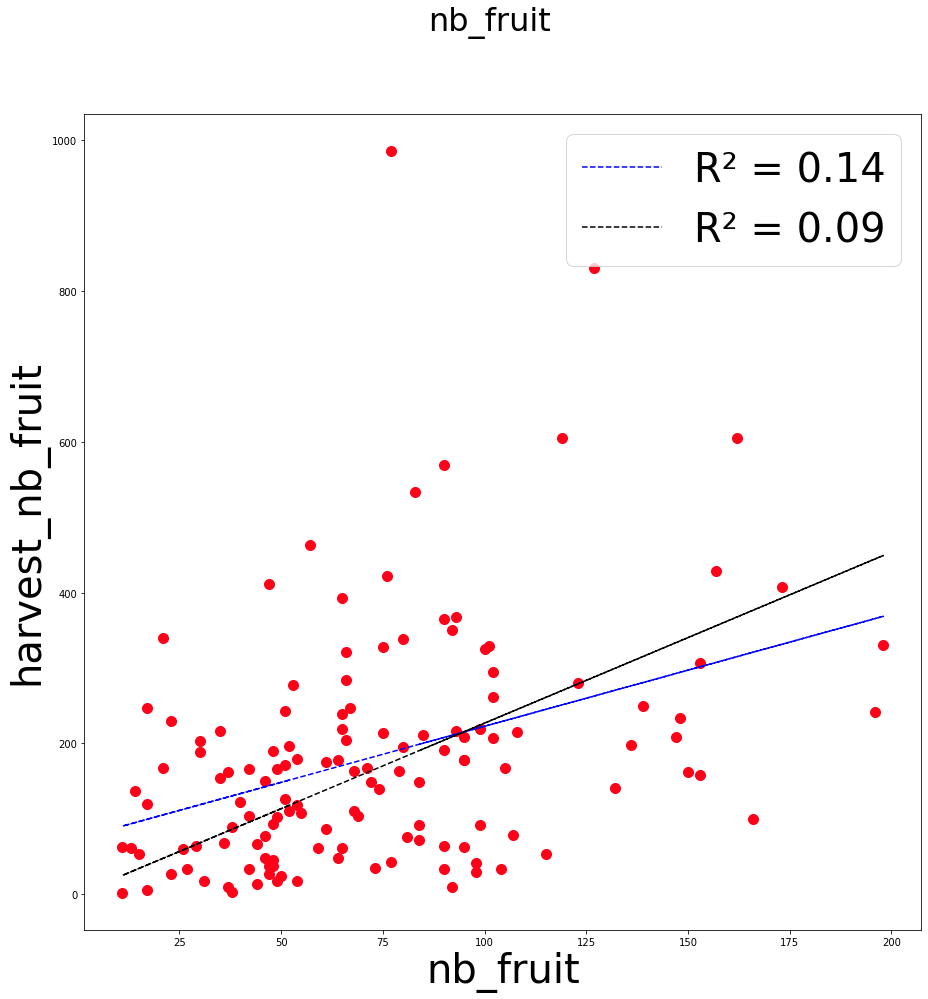

In [14]:
matplotlib.pyplot.rcParams["figure.figsize"] = (15, 15)

camp = matplotlib.pyplot.get_cmap('hsv', 1)
fig = matplotlib.pyplot.figure()
axis = matplotlib.pyplot.axes()
    
fig.suptitle('nb_fruit', fontsize=32)
plot_R2_linear_model(axis,
                        df_comparison['nb_fruit'],
                        df_comparison['harvest_nb_fruit'], 
                        color=camp(0))

matplotlib.pyplot.savefig("field_RF_DBSCAN_1&5.png")
matplotlib.pyplot.show()

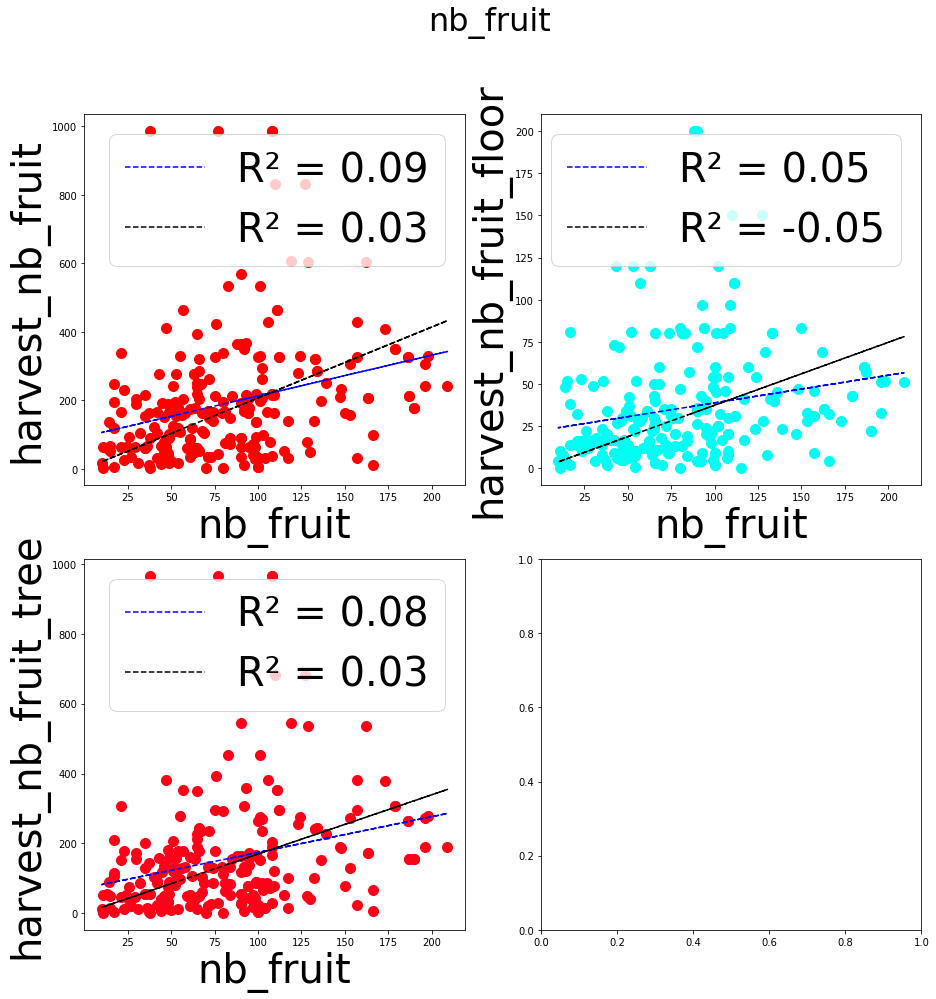

In [21]:
# matplotlib.pyplot.rcParams["figure.figsize"] = (15, 15)

elements = ['harvest_nb_fruit', 
            'harvest_nb_fruit_floor',
            'harvest_nb_fruit_tree']

# TODO: plot ecart type
camp = matplotlib.pyplot.get_cmap('hsv', len(elements))
for name_1 in ['nb_fruit']:
    fig, axis = matplotlib.pyplot.subplots(2, 2)
    
    fig.suptitle(name_1, fontsize=32)
    
    for i, name_2 in enumerate(elements):
        
        plot_R2_linear_model(axis.flat[i],
                             df_comparison[name_1],
                             df_comparison[name_2], 
                             color=camp(i))
    matplotlib.pyplot.show()

KeyError: 'nb_point'

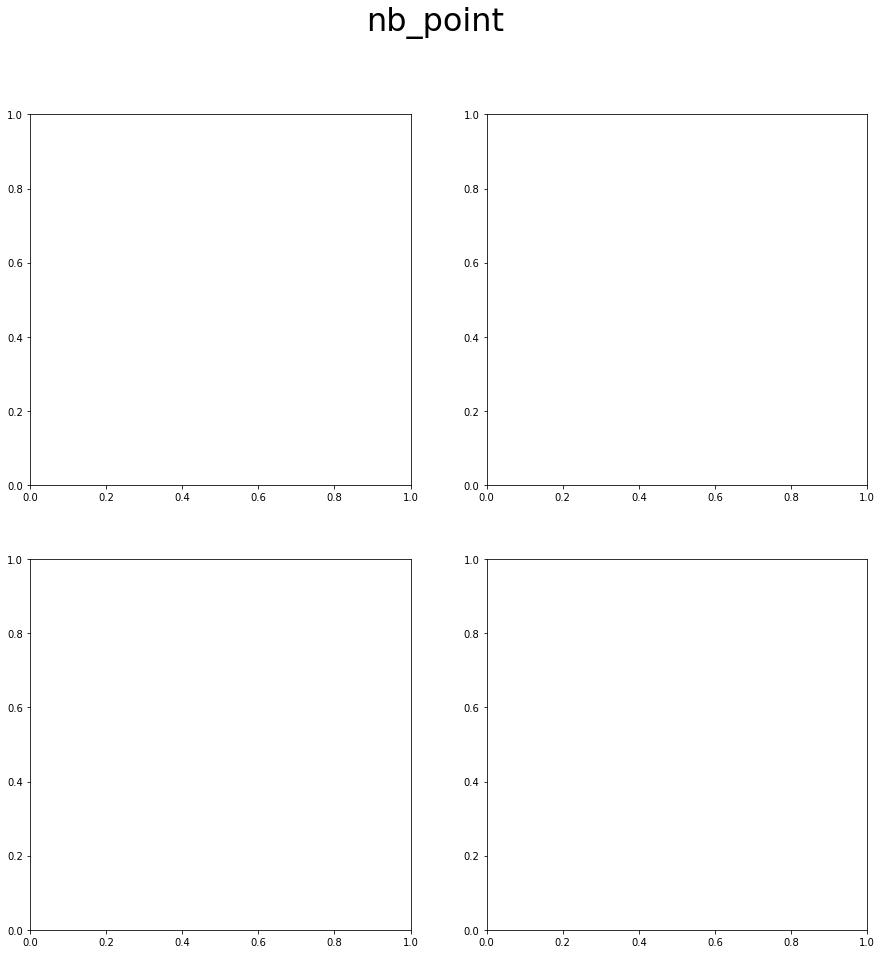

In [16]:
elements = ['harvest_weight_fruit', 
            'harvest_weight_fruit_floor',
            'harvest_weight_fruit_tree']

# TODO: plot ecart type
camp = matplotlib.pyplot.get_cmap('hsv', len(elements))
for name_1 in ['nb_point', 'nb_point_of_fruit']:
    fig, axis = matplotlib.pyplot.subplots(2, 2)
    
    fig.suptitle(name_1, fontsize=32)
    
    for i, name_2 in enumerate(elements):
        
        plot_R2_linear_model(axis.flat[i],
                             df_comparison[name_1],
                             df_comparison[name_2], 
                             color=camp(i))
    matplotlib.pyplot.show()